# Metrics

We saw before that the notion of "distance" between vector-valued objects is not simple like in scalar real numbers. There is more information on this [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

Most people associate distance between two points to the `euclidean` distance (the hypotenuse of their coordinates). Others include:

- Cosine distance (angle between vectors)

- Manhattan AKA "cityblock" or "taxicab" (euclidean by going along square grid)

- Minkowsky (uses a parameter p to generalize between manhattan and euclidean)

- Mahalanobis (measures how many standard deviations away from each other the points are)

The cosine distance is not a distance metric proper, so is not always included in metric packages. But the good news is that the euclidean distance on a normalized vector is equivalent.

# Relative Scale

This also means that if relative scales on features are different, they will "pull too hard" and destroy any chance you have of success.

One way to do this is to normalize each feature.

One good way to merge all of the different data types together into a clustering is by using [Gower Distance](https://dpmartin42.github.io/posts/r/cluster-mixed-types).

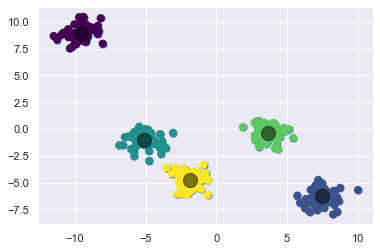

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
sns.set()

N_CLUSTERS = 5

X, y_true = make_blobs(n_samples=300, centers=N_CLUSTERS,
                       cluster_std=0.70, random_state=33)
plt.scatter(X[:, 0], X[:, 1], s=50)

kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

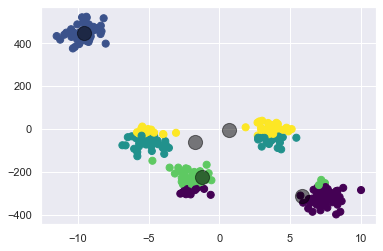

In [6]:
### Rescale X
X[:, 1] *= 50

### Do the same as before, now it fails
kmeans2 = KMeans(n_clusters=N_CLUSTERS)
kmeans2.fit(X)
y_kmeans = kmeans2.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The above fails to cluster because distances on the y-axis are now so much large it's easier to jump across clusters than to traverse y-axis.

**REMINDER:** Always normalize distances before using them in clustering! Unlike regression, where coefficients "scale" the features, when taking distances you need to fix it yourself beforehand.

# Evaluating Clustering

Information can be found [here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

Computing adjusted_rand_score for 10 values of n_clusters and n_samples=100
done in 0.040s
Computing v_measure_score for 10 values of n_clusters and n_samples=100
done in 0.052s
Computing ami_score for 10 values of n_clusters and n_samples=100
done in 0.395s
Computing mutual_info_score for 10 values of n_clusters and n_samples=100
done in 0.045s
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=1000
done in 0.047s
Computing v_measure_score for 10 values of n_clusters and n_samples=1000
done in 0.069s
Computing ami_score for 10 values of n_clusters and n_samples=1000
done in 0.241s
Computing mutual_info_score for 10 values of n_clusters and n_samples=1000
done in 0.055s


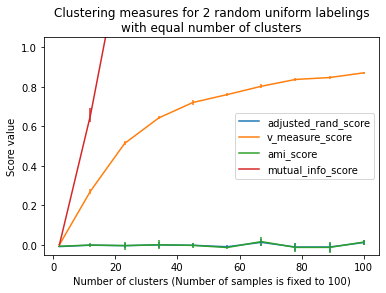

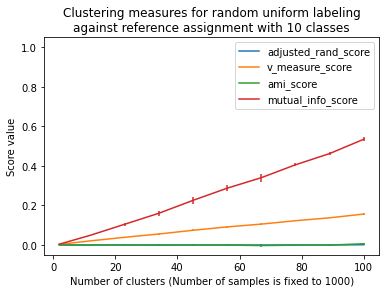

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics

def uniform_labelings_scores(score_func, n_samples, n_clusters_range,
                             fixed_n_classes=None, n_runs=5, seed=42):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range), n_runs))

    if fixed_n_classes is not None:
        labels_a = random_labels(low=0, high=fixed_n_classes, size=n_samples)

    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0, high=k, size=n_samples)
            labels_b = random_labels(low=0, high=k, size=n_samples)
            scores[i, j] = score_func(labels_a, labels_b)
    return scores


def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]

# 2 independent random clusterings with equal cluster number

n_samples = 100
n_clusters_range = np.linspace(2, n_samples, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters and n_samples=%d"
          % (score_func.__name__, len(n_clusters_range), n_samples))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range)
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for 2 random uniform labelings\n"
          "with equal number of clusters")
plt.xlabel('Number of clusters (Number of samples is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)


# Random labeling with varying n_clusters against ground class labels
# with fixed number of clusters

n_samples = 1000
n_clusters_range = np.linspace(2, 100, 10).astype(int)
n_classes = 10

plt.figure(2)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters and n_samples=%d"
          % (score_func.__name__, len(n_clusters_range), n_samples))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_samples, n_clusters_range,
                                      fixed_n_classes=n_classes)
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, scores.mean(axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for random uniform labeling\n"
          "against reference assignment with %d classes" % n_classes)
plt.xlabel('Number of clusters (Number of samples is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()

# Selecting the number of clusters with silhouette analysis on KMeans clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of \[-1, 1\].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872
For n_clusters = 6 The average silhouette_score is : 0.4387644975296138


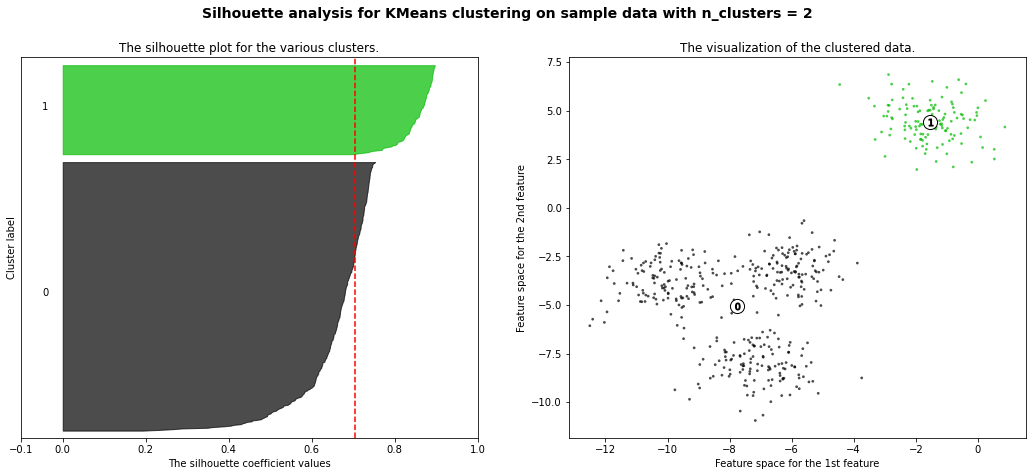

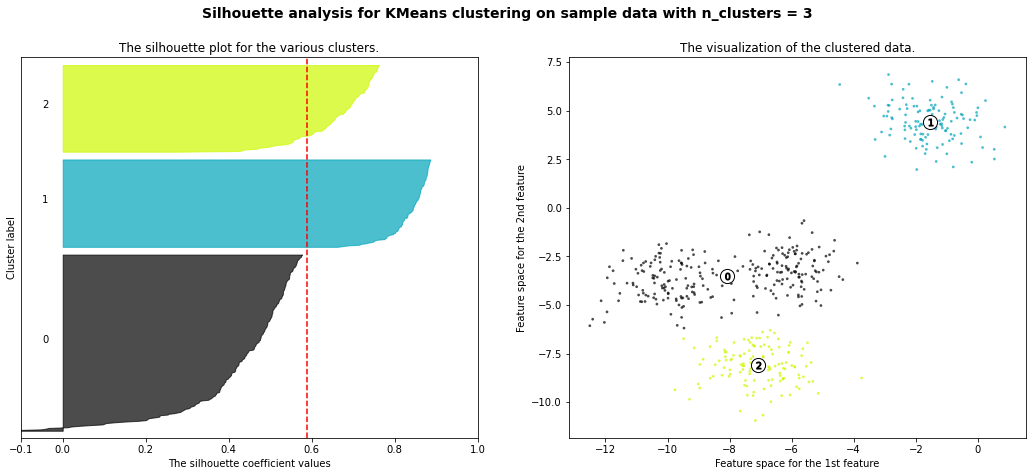

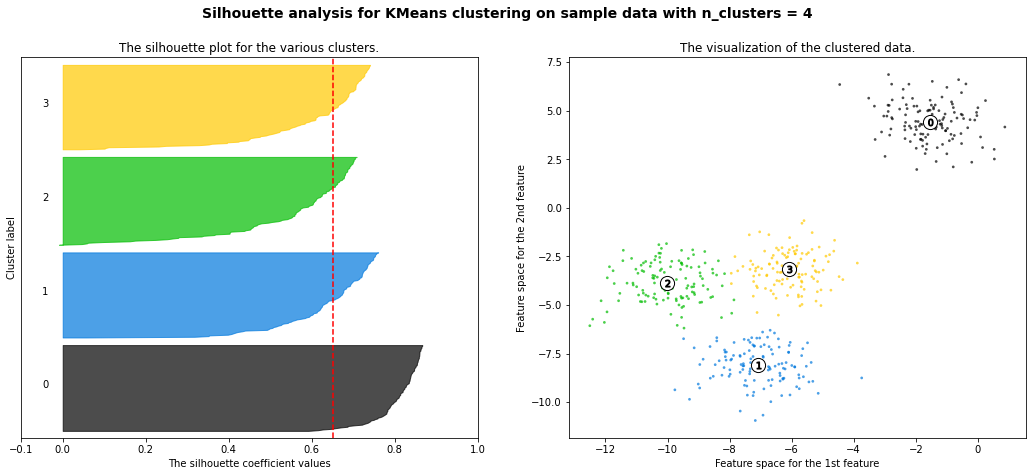

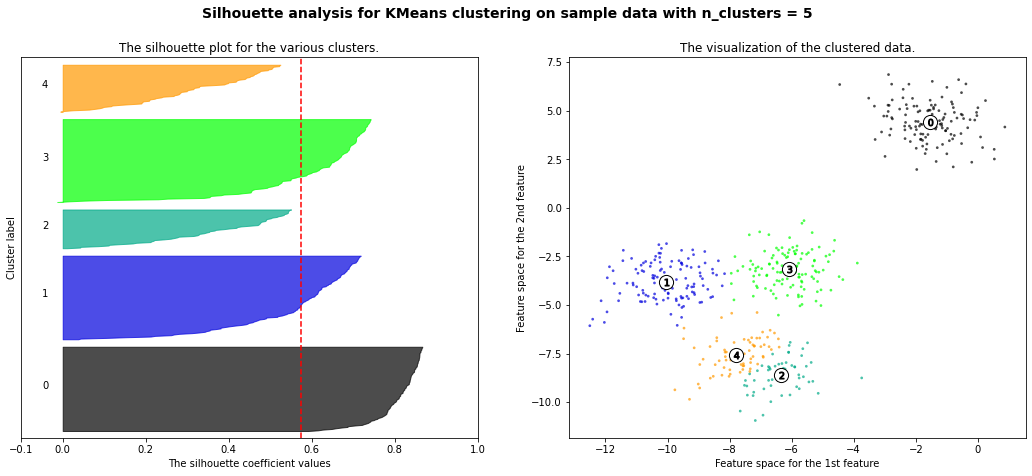

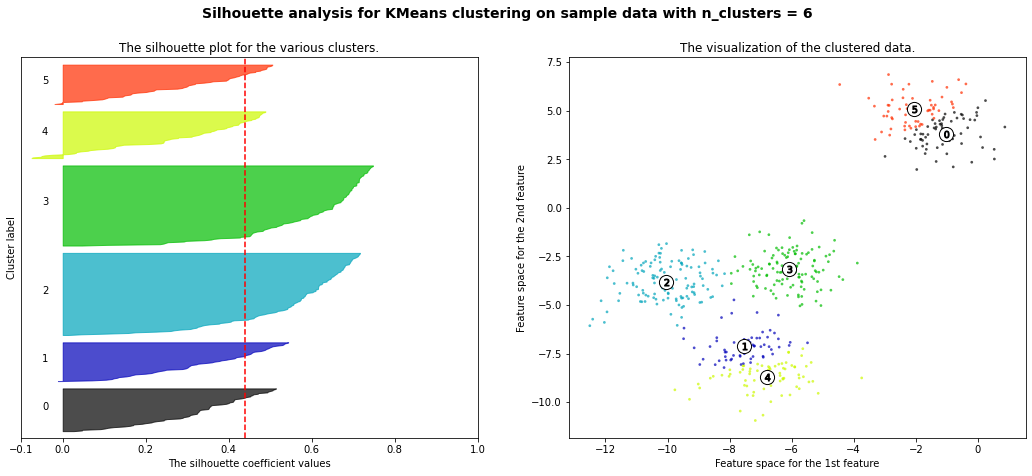

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()